In [27]:
import pandas as pd
df = pd.read_csv('all-data.csv', header=None, encoding='latin1')
print(df.head())
print(df.columns)


          0                                                  1
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...
Index([0, 1], dtype='int64')


In [28]:

df.columns = ['label', 'article']
print(df.head())


      label                                            article
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [29]:
print(df.columns)


Index(['label', 'article'], dtype='object')


In [30]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
df = pd.read_csv('all-data.csv', encoding='latin1')

df.columns = ['label', 'article']  

print(df.head())


nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
 
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I)
    text = text.lower()
    
  
    words = text.split()
    words = [word for word in words if word not in stop_words]
   
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

df['processed_text'] = df['article'].apply(preprocess_text)

print(df.head())


      label                                            article
0   neutral  Technopolis plans to develop in stages an area...
1  negative  The international electronic industry company ...
2  positive  With the new production plant the company woul...
3  positive  According to the company 's updated strategy f...
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


      label                                            article  \
0   neutral  Technopolis plans to develop in stages an area...   
1  negative  The international electronic industry company ...   
2  positive  With the new production plant the company woul...   
3  positive  According to the company 's updated strategy f...   
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...   

                                      processed_text  
0  technopolis plan develop stage area less 0,000...  
1  international electronic industry company elco...  
2  new production plant company would increase ca...  
3  according company updated strategy year 009-20...  
4  financing aspocomp growth aspocomp aggressivel...  


In [31]:
# Check how the labels are mapped
print(df['label'].value_counts())  # Check the distribution of sentiment labels

# Double-check the mapping if you haven't already
y = df['label'].map({'positive': 1, 'negative': 0, 'neutral': 2})

# Split dataset into features and labels
X = df['processed_text']


label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64


In [32]:
from sklearn.model_selection import train_test_split

# Split dataset into features and labels
X = df['processed_text']
y = df['label']  # Assuming 'sentiment' contains the labels (positive, negative, neutral)

# Convert the labels into numeric values (if not already done)
y = y.map({'positive': 1, 'negative': 0, 'neutral': 2})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training Machine Learning Model for Sentiment Analysis

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to ensure they are of the same length
max_sequence_length = 100  # You can adjust this based on your dataset
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 classes: positive, negative, neutral

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))


Epoch 1/5
61/61 [==============================] - 24s 338ms/step - loss: 0.8952 - accuracy: 0.6140 - val_loss: 0.8099 - val_accuracy: 0.6264
Epoch 2/5
61/61 [==============================] - 20s 323ms/step - loss: 0.6179 - accuracy: 0.7273 - val_loss: 0.7989 - val_accuracy: 0.6873
Epoch 3/5
61/61 [==============================] - 23s 373ms/step - loss: 0.3127 - accuracy: 0.8829 - val_loss: 0.8783 - val_accuracy: 0.6935
Epoch 4/5
61/61 [==============================] - 21s 345ms/step - loss: 0.1636 - accuracy: 0.9438 - val_loss: 0.9483 - val_accuracy: 0.6966
Epoch 5/5
61/61 [==============================] - 19s 309ms/step - loss: 0.0916 - accuracy: 0.9688 - val_loss: 1.3006 - val_accuracy: 0.6956


Accuracy

In [35]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


31/31 [==============================] - 1s 25ms/step - loss: 1.3006 - accuracy: 0.6956
Test Accuracy: 0.6956


 Prediction

In [36]:
def predict_sentiment(news_text):
    # Preprocess the input text
    processed_text = preprocess_text(news_text)
    
    # Convert text to sequence and pad
    seq = tokenizer.texts_to_sequences([processed_text])
    padded_seq = pad_sequences(seq, maxlen=max_sequence_length)
    
    # Predict sentiment
    pred = model.predict(padded_seq)
    
    # Get the label with the highest probability
    sentiment_labels = ['negative', 'positive', 'neutral']
    sentiment = sentiment_labels[pred.argmax()]
    
    return sentiment

# Example usage
new_article = 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .'
predicted_sentiment = predict_sentiment(new_article)
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 [==============================] - 0s 312ms/step
Predicted Sentiment: negative


In [37]:
df['article'][1]

'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .'

In [38]:
df['article'][50]

"The world 's second largest stainless steel maker said net profit in the three-month period until Dec. 31 surged to euro603 million US$ 781 million , or euro3 .33 US$ 4.31 per share , from euro172 million , or euro0 .94 per share , the previous year ."

In [39]:
df['label'][1]

'negative'

Data Visualizatin

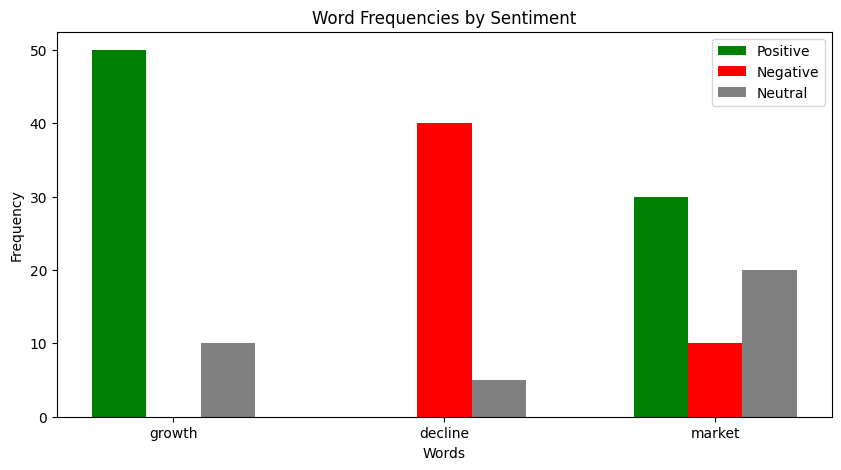

In [40]:
import matplotlib.pyplot as plt

# Example data
words = ['growth', 'decline', 'market']
frequencies_positive = [50, 0, 30]
frequencies_negative = [0, 40, 10]
frequencies_neutral = [10, 5, 20]

# Plot Bar Chart
x = range(len(words))
width = 0.2

plt.figure(figsize=(10, 5))
plt.bar([p - width for p in x], frequencies_positive, width, label='Positive', color='green')
plt.bar(x, frequencies_negative, width, label='Negative', color='red')
plt.bar([p + width for p in x], frequencies_neutral, width, label='Neutral', color='gray')

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequencies by Sentiment')
plt.xticks(x, words)
plt.legend()
plt.show()


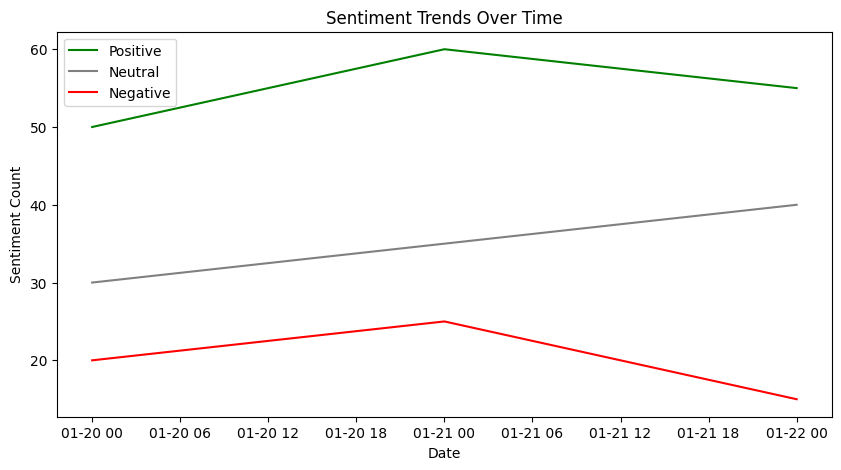

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data
data = {'Date': ['2025-01-20', '2025-01-21', '2025-01-22'],
        'Positive': [50, 60, 55],
        'Neutral': [30, 35, 40],
        'Negative': [20, 25, 15]}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Plot Time-Series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Positive'], label='Positive', color='green')
plt.plot(df['Date'], df['Neutral'], label='Neutral', color='gray')
plt.plot(df['Date'], df['Negative'], label='Negative', color='red')

plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Trends Over Time')
plt.legend()
plt.show()


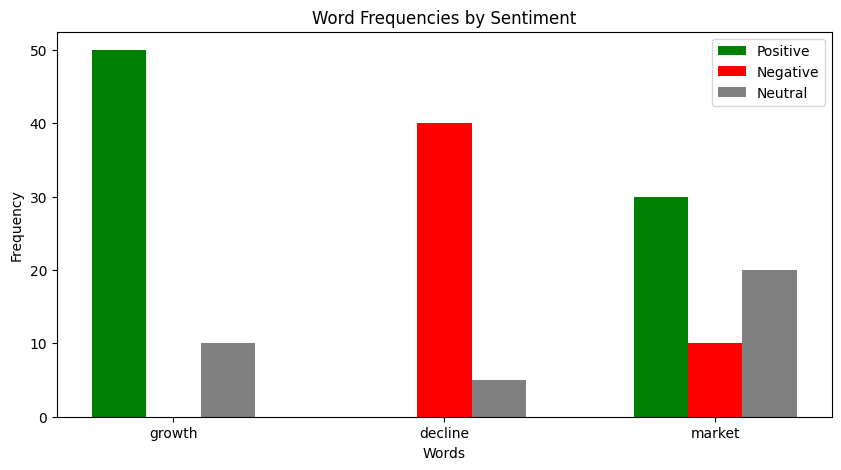

In [42]:

import matplotlib.pyplot as plt

# Example data
words = ['growth', 'decline', 'market']
frequencies_positive = [50, 0, 30]
frequencies_negative = [0, 40, 10]
frequencies_neutral = [10, 5, 20]

# Plot Bar Chart
x = range(len(words))
width = 0.2

plt.figure(figsize=(10, 5))
plt.bar([p - width for p in x], frequencies_positive, width, label='Positive', color='green')
plt.bar(x, frequencies_negative, width, label='Negative', color='red')
plt.bar([p + width for p in x], frequencies_neutral, width, label='Neutral', color='gray')

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequencies by Sentiment')
plt.xticks(x, words)
plt.legend()
plt.show()
